In [1]:
%load_ext nb_black


import pandas as pd
import numpy as np
import os
import glob
path="processed_gdelt2/"

pd.set_option('display.max_columns', 150)

from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ciso8601
from datetime import datetime
from dateutil import parser
import concurrent.futures
import time
import csv
import re


import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots

ply.init_notebook_mode(connected=True)


import colorlover as cl
from IPython.display import HTML

chosen_colors=cl.scales['7']['qual'][np.random.choice(list(cl.scales['7']['qual'].keys()))]

print('The color palette chosen for this notebook is:')
HTML(cl.to_html(chosen_colors))

The color palette chosen for this notebook is:


<IPython.core.display.Javascript object>

In [2]:
files = glob.glob(os.path.join(path,"2019*.csv"))
len(files)

35020

<IPython.core.display.Javascript object>

In [3]:
headers = ['gkg_id', 'date', 'source', 'source_name', 'doc_id', 
        'themes', 'locations', 'persons', 'orgs', 
        'tone', 'pos', 'neg', 'polarity', 'ard', 'srd',
        'wc', 
        'lexicode_neg', 'lexicode_pos', # c3.*
        'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
        'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
        'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
        'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
        'INTL_AFFAIRS', 'GOVERNMENT_OPS',
        'LAND-WATER-MANAGEMENT', 'CULTURE',
        'PROV_LOCAL', 'INTERGOVERNMENTAL',
        'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
        'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
        'FORESTRY', 'LABOUR', 'IMMIGRATION',
        'EDUCATION', 'ENVIRONMENT',
        'finstab_pos', 'finstab_neg', 'finstab_neutral',
        'finsent_neg', 'finsent_pos', 'finsent_unc',
        'opin_neg', 'opin_pos',
        'sent_pos', 'sent_neg', 'sent_pol'
]

<IPython.core.display.Javascript object>

In [4]:
''' Tone--- (floating point number) This is the average “tone” of the document as a whole.
The score ranges from -100 (extremely negative) to +100 (extremely positive). Common
values range between -10 and +10, with 0 indicating neutral. '''

''' Positive Score--- (floating point number) This is the percentage of all words in the article
that were found to have a positive emotional connotation. Ranges from 0 to +100. '''

''' Negative Score--- (floating point number) This is the percentage of all words in the
article that were found to have a positive emotional connotation. Ranges from 0 to
+100. '''

''' Polarity--- (floating point number) This is the percentage of words that had matches in
the tonal dictionary as an indicator of how emotionally polarized or charged the text is.
If Polarity is high, but Tone is neutral, this suggests the text was highly emotionally
charged, but had roughly equivalent numbers of positively and negatively charged
emotional words. '''


''' c 3.4 --- negative positive ( positive word preceded by a negation (used to convey negative sentiment) and, 
    c 3.3 --- negative negative ( a negative word preceded by a negation, used to convey positive sentiment )'''

def merge_csv():
    start = time.time()
#     df_each = (pd.read_csv(f,names=headers,header=None) for f in files)
#     df_merge = pd.concat(df_each, ignore_index=True)
#     df = df_merge.copy()
#     end = time.time()
#     print(f"Processing the data took : {round(end-start,2)} seconds")
    
    header_written = False
    ''' Pandas method takes a longer timer for merge and hence have made it in pure python to boost up'''

#     with open('gdelt.csv', 'w', newline="") as fout:                         # merge csv
#         wout = csv.writer(fout, delimiter=',')
#         files = [x for x in glob.glob("processed_gdelt2/2020*.csv") if x != 'gdelt.csv']
#         for file in files:
#             print("processing {}".format(file))
#             with open(file) as fin:
#                 cr = csv.reader(fin,delimiter=',')
#                 if not header_written:
#                     wout.writerow(headers)
#                     header_written = True
#                 wout.writerows(cr)    
    
    df = pd.read_csv("Gdelt_2020.csv")
    df_au = pd.read_csv("gdelt_2020_au.csv")
    df_nz_2019 = pd.read_csv("gdelt_2019_NZ.csv")




#     df['date'].dropna(inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d%H%M%S")
    df_au['date'] = pd.to_datetime(df_au['date'], format = "%Y%m%d%H%M%S")
    
    df_nz_2019['date'] = pd.to_datetime(df_nz_2019['date'], format = "%Y%m%d%H%M%S")
    df_nz_2019['month'] = df_nz_2019['date'].dt.strftime('%b')


    

    end = time.time()
    print(f"Processing the datetime took : {round(end-start,2)} seconds")

    
    return df, df_au, df_nz_2019



<IPython.core.display.Javascript object>

In [5]:
%%time

df1,df1_au,df_nz_2019 = merge_csv()


Processing the datetime took : 94.62 seconds
CPU times: user 1min 13s, sys: 6.96 s, total: 1min 20s
Wall time: 1min 34s


<IPython.core.display.Javascript object>

In [6]:
print(df1['date'].min())
print(df1['date'].max())

2020-01-01 00:00:00
2020-12-31 23:45:00


<IPython.core.display.Javascript object>

### Lockdown Feature inclusion


In [7]:
''' 2020/03/21 - Alert level 2
    2020/03/23  - Alert level 3
    2020/03/25  - Alert level 4
    2020/04/27 - 3
    2020/05/13 - 2
    2020/06/08 - 1
    2020/08/12 - A 3 & R 2
    2020/08/30 - 2
    2020/09/21 - A2 & R1
    2020/10/7  - 1
    2021/02/14 - A 3 R 2
    2021/02/17 - A 2 R 1 
    2021/02/28 - A 3 R 1
    2021/03/07 - A 2 R 1
    2021/03/12 - 1
    '''

unique_dates = pd.to_datetime(df1['date'].unique())
date_to_lockdown = {}
for date in unique_dates:

    date_str = date.strftime('%Y%m%d')
    if date < datetime(2020, 3, 23):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 3, 25):
        date_to_lockdown[date_str] = 'AL 3'
    elif date < datetime(2020, 4, 27):
        date_to_lockdown[date_str] = 'AL 4'
    elif date < datetime(2020, 5, 13):
        date_to_lockdown[date_str] = 'AL 3'
    elif date < datetime(2020, 6, 8):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 8, 12):
        date_to_lockdown[date_str] = 'AL 1'
    elif date < datetime(2020, 8, 30):
        date_to_lockdown[date_str] = 'AKL-3 Rest-2'
    elif date < datetime(2020, 9, 21):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 10, 7):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    elif date < datetime(2021, 2, 14):
        date_to_lockdown[date_str] = 'AL 1'
    elif date < datetime(2021, 2, 17):
        date_to_lockdown[date_str] = 'AKL-3 Rest-2'
    elif date < datetime(2021, 2, 28):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    elif date < datetime(2021, 3, 7):
        date_to_lockdown[date_str] = 'AKL-3 Rest-1'
    elif date < datetime(2021, 3, 12):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    else:
        date_to_lockdown[date_str] ='AL 1'

df1['Lockdown'] = df1['date'].dt.strftime('%Y%m%d').map(date_to_lockdown)

<IPython.core.display.Javascript object>

In [10]:
# df1 = pd.read_feather('df1.ft')      # cleaned df

In [8]:
au_city = pd.read_csv("au.csv")    # extracting Australia cities
au_city = list(au_city['city'])
au_city = au_city[:15]

<IPython.core.display.Javascript object>

### Region Wise Analysis

In [9]:
regions = [
    "Northland", "Auckland", "Waikato", "Bay of Plenty", "Gisborne", 
    "Hawke's Bay", "Taranaki", "Manawatu-Whanganui", "Wellington", "Tasman",
    "Nelson", "Marlborough", "West Coast", "Canterbury", "Otago", "Southland"
]

df1['Region'] = df1['locations'].str.findall(r"|".join(regions)).apply(", ".join)

df1_au['Region'] = df1_au['locations'].str.findall(r"|".join(au_city)).apply(", ".join)


<IPython.core.display.Javascript object>

In [10]:
def region(region):
    
    region = region.split(',')
    region = [region.replace(' ', '') for region in region]
#     region = list(filter(lambda x: x.strip(), region))
    region = list(set(region))
    region = ["New Zealand (General)" if region == '' else region for region in region]
    
    return region

def region_au(region):
    
    region = region.split(',')
    region = [region.replace(' ', '') for region in region]
#     region = list(filter(lambda x: x.strip(), region))
    region = list(set(region))
    region = ["Australia (General)" if region == '' else region for region in region]
    
    return region

df1['Region'] = df1['Region'].apply(lambda x: region(x))

df1_au['Region'] = df1_au['Region'].apply(lambda x: region_au(x))


# list to str

df1['Region'] = df1['Region'].agg(lambda x: ','.join(map(str, x)))

df1_au['Region'] = df1_au['Region'].agg(lambda x: ','.join(map(str, x)))

def reg(df1):
    test = ','.join(df1['Region'])
    test = test.split(',')
    d = Counter(test)
    df_Region = pd.DataFrame.from_dict(d, orient='index').reset_index()
    df_Region.columns = ['Region', 'Count']
    df_Region.sort_values(by = 'Count', ascending=False, inplace=True)
    
    return df_Region

<IPython.core.display.Javascript object>

In [11]:
df_Region = reg(df1)
df_Region_au = reg(df1_au)

<IPython.core.display.Javascript object>

In [12]:
# df1['Region'] = [[region] for region in df1['Region']]

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top News Channel in 2020')

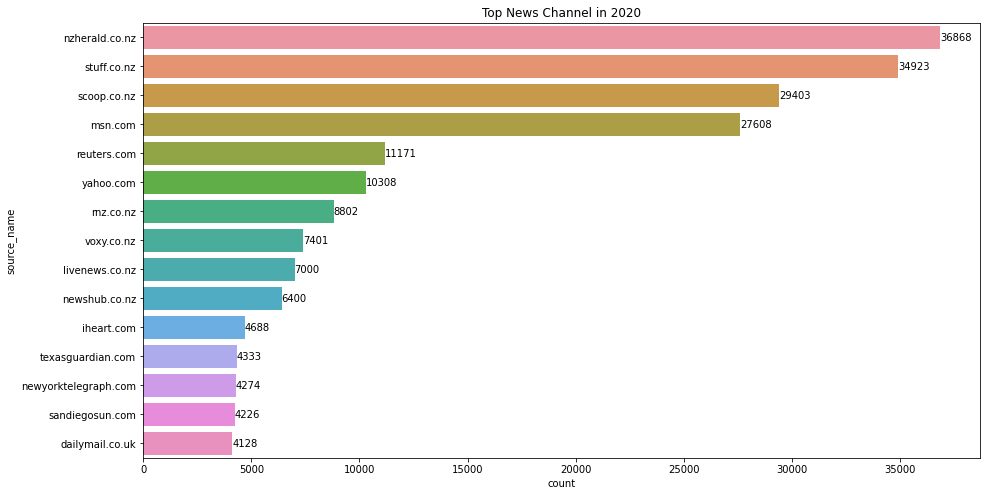

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(15,8))
ax=sns.countplot(y='source_name',data=df1, order=df1.source_name.value_counts().iloc[:15].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channel in 2020")
# plt.xlabel("No")

In [14]:
# Counter(','.join(df1['Region']).replace(' ', '').split(','))

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top News Region wise in 2020 - New Zealand')

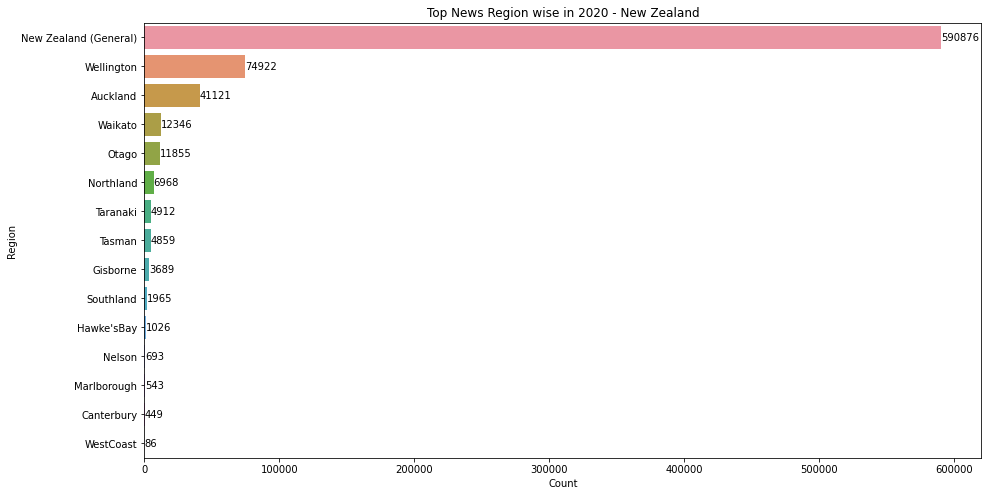

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='Count' ,y='Region',data=df_Region)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Region wise in 2020 - New Zealand")
# plt.xlabel("No")

In [16]:
df1['Region'] = df1['Region'].apply(lambda x: list(x.split(',')))

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top News city wise in 2020 - Australia')

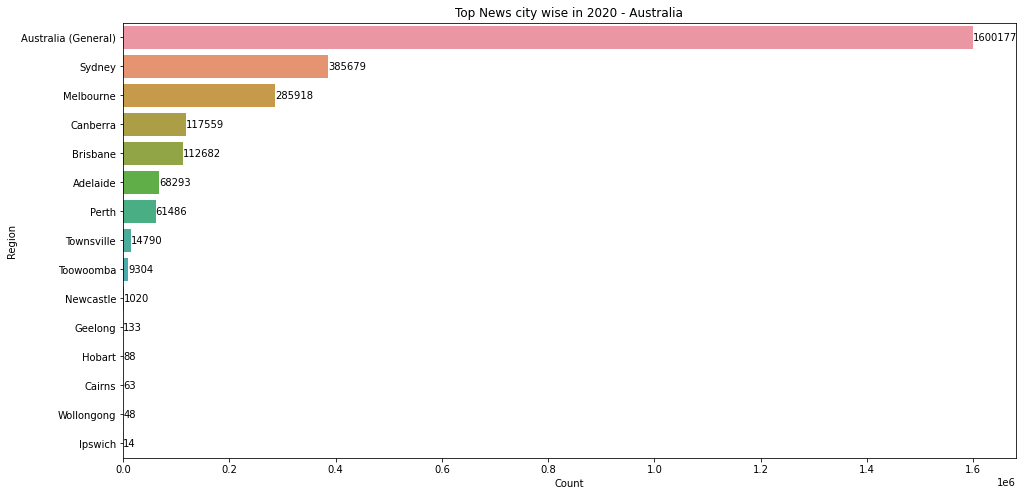

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(16,8))
ax=sns.barplot(x='Count' ,y='Region',data=df_Region_au)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News city wise in 2020 - Australia")

In [18]:
df1['Sentiment'] = df1['tone'].apply(lambda x: "Positive" if x>0 else ("Neutral" if x==0 else "Negative"))
df1_au['Sentiment'] = df1_au['tone'].apply(lambda x: "Positive" if x>0 else ("Neutral" if x==0 else "Negative"))

<IPython.core.display.Javascript object>

Text(0.5, 1.0, ' Region wise Sentiment in 2020 - New Zealand')

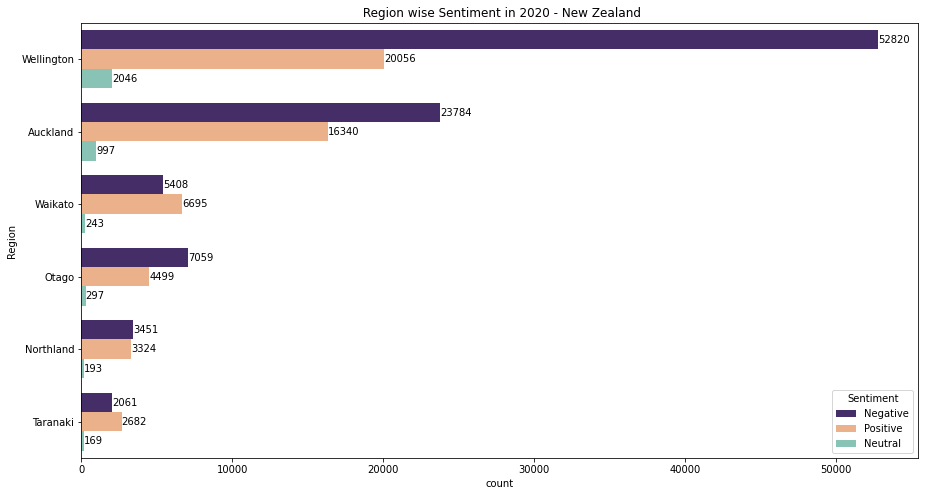

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(15,8))
ax=sns.countplot(y=df1.explode('Region').Region ,data=df1, hue = df1.explode('Region').Sentiment, order = df_Region.Region[1:7], palette=['#432371',"#FAAE7B", "#7fcdbb"])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title(" Region wise Sentiment in 2020 - New Zealand")
# plt.xlabel("No")

Text(0.5, 1.0, 'Region wise Sentiment in 2020 - Australia')

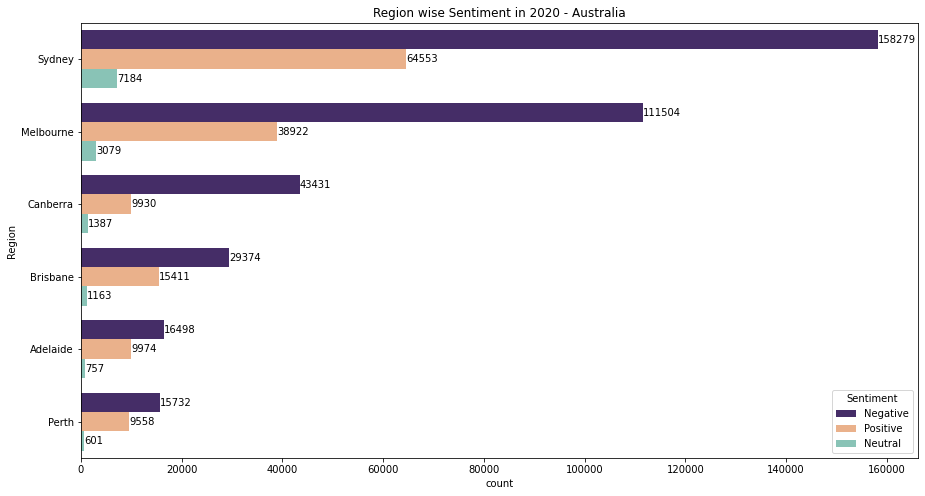

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(15,8))
ax=sns.countplot(y=df1_au.explode('Region').Region ,data=df1_au, hue = df1_au.explode('Region').Sentiment, order = df_Region_au.Region[1:7], palette=['#432371',"#FAAE7B", "#7fcdbb"])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.title("Region wise Sentiment in 2020 - Australia")

In [21]:
df1_analysis_source = df1.groupby(['source_name', 'Sentiment']).agg({'Sentiment': ['count']}).reset_index()#.sort_values(by = 'Sentiment')
df1_analysis_source_au = df1_au.groupby(['source_name', 'Sentiment']).agg({'Sentiment': ['count']}).reset_index()#.sort_values(by = 'Sentiment')

<IPython.core.display.Javascript object>

In [22]:
df1_analysis_source.columns = df1_analysis_source.columns.droplevel(0)
df1_analysis_source_au.columns = df1_analysis_source_au.columns.droplevel(0)

<IPython.core.display.Javascript object>

In [23]:
df1_analysis_source.columns=['source_name', 'Sentiment', 'count']
df1_analysis_source_au.columns=['source_name', 'Sentiment', 'count']

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Count of Articles')

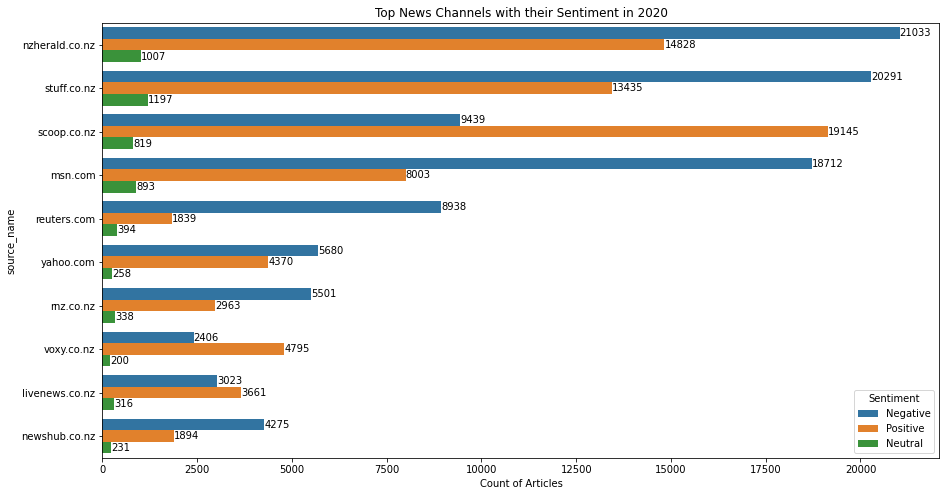

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='count',y='source_name',data=df1_analysis_source, hue = 'Sentiment', order=df1.source_name.value_counts().iloc[:10].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels with their Sentiment in 2020")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

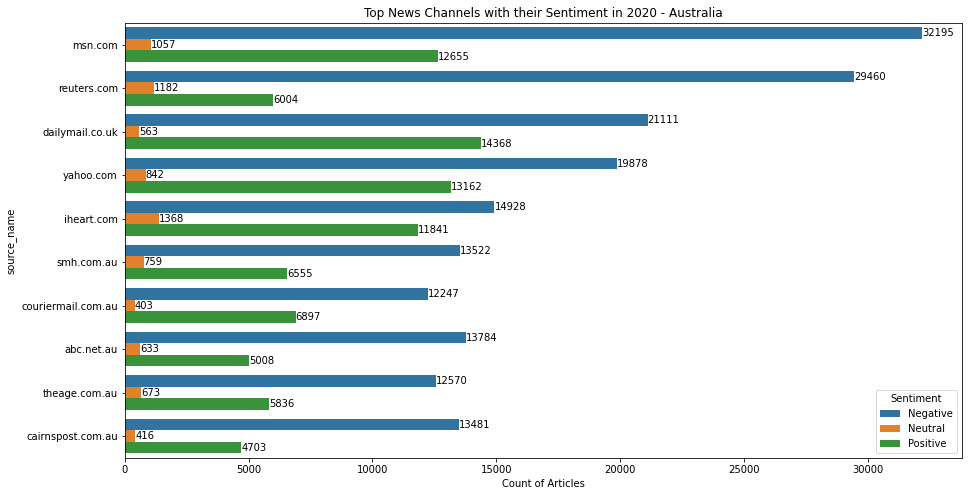

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='count',y='source_name',data=df1_analysis_source_au, hue = 'Sentiment', order=df1_au.source_name.value_counts().iloc[:10].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels with their Sentiment in 2020 - Australia")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

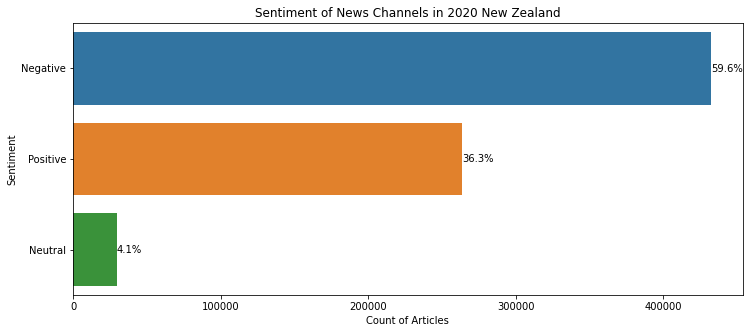

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(12,5))
ax=sns.countplot(y='Sentiment',data=df1)
total = float(len(df1))
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:.1f}%'.format(100 * width/ total), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Sentiment of News Channels in 2020 New Zealand")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

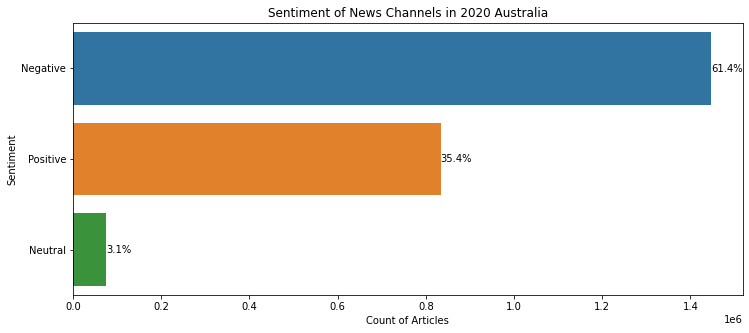

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(12,5))
ax=sns.countplot(y='Sentiment',data=df1_au)
total = float(len(df1_au))
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:.1f}%'.format(100 * width/ total), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Sentiment of News Channels in 2020 Australia")
plt.xlabel("Count of Articles")

In [28]:
# df1.to_feather('df1.ft')

<IPython.core.display.Javascript object>

In [29]:
df1[df1['date'] == datetime(2020, 5, 26)]['tone'].mean()

-0.17806446491455835

<IPython.core.display.Javascript object>

### scraping Hedonometer events api

In [30]:


def hedono_api():
    response = requests.get("http://hedonometer.org/api/v1/events/?format=json&happs__timeseries__title=en_all&happs__date__gte=2019-11-01")

    print(response.status_code)

    x = response.json()
    x = json.dumps(x)
    json_parsed = json.loads(x)

    obj = json_parsed['objects']

    f = csv.writer(open("events.csv", "w"))

    h = ["date","happiness","shorter"]

    f.writerow(h)

    for x in obj:
        f.writerow([x['happs']['date'],
                    x['happs']['happiness'],
                    x['shorter']])

        
df_events = pd.read_csv("events.csv", parse_dates=['date'])

<IPython.core.display.Javascript object>

In [31]:
df1['date'] =  pd.to_datetime(df1['date'])
df1_au['date'] =  pd.to_datetime(df1_au['date'])

<IPython.core.display.Javascript object>

In [32]:
df1 = pd.merge(df1, df_events, on="date", how="left")
df1_au = pd.merge(df1_au, df_events, on="date", how="left")

<IPython.core.display.Javascript object>

### Comparison of Hedonometer vs GDELT

In [33]:
df1.groupby(['shorter', 'date','happiness'], as_index=False).agg({'Sentiment': pd.Series.mode}).sort_values(by = 'date')

,shorter,date,happiness,Sentiment
11,"New Year's,Day",2020-01-01,6.070,Positive
5,"Death of,Qasem Soleimani",2020-01-03,5.783,Negative
8,"Iranian,missile attack",2020-01-07,5.882,Negative
4,"Death of,Kobe Bryant",2020-01-26,5.895,Positive
16,"Valentine's,Day",2020-02-14,6.040,Negative
1,"COVID-19,Pandemic",2020-03-12,5.713,Negative
0,"Arrests for murder, of Ahmaud Arbery",2020-05-07,5.871,Negative
9,"Mother's,Day",2020-05-10,5.958,"[Negative, Positive]"
10,"Murder of,George Floyd",2020-05-26,5.870,Negative
13,"Protests against,police brutality",2020-05-31,5.628,Negative


<IPython.core.display.Javascript object>

In [34]:
df1_au.groupby(['shorter', 'date','happiness'], as_index=False).agg({'Sentiment': pd.Series.mode}).sort_values(by = 'date')

,shorter,date,happiness,Sentiment
11,"New Year's,Day",2020-01-01,6.070,Negative
5,"Death of,Qasem Soleimani",2020-01-03,5.783,Negative
8,"Iranian,missile attack",2020-01-07,5.882,Negative
4,"Death of,Kobe Bryant",2020-01-26,5.895,Negative
16,"Valentine's,Day",2020-02-14,6.040,Negative
1,"COVID-19,Pandemic",2020-03-12,5.713,Negative
0,"Arrests for murder, of Ahmaud Arbery",2020-05-07,5.871,Negative
9,"Mother's,Day",2020-05-10,5.958,Positive
10,"Murder of,George Floyd",2020-05-26,5.870,Negative
13,"Protests against,police brutality",2020-05-31,5.628,Negative


<IPython.core.display.Javascript object>

### Lockdown Analysis

In [37]:
df_lockdown = df1.groupby(['source_name','Lockdown', 'Sentiment'], as_index=False).agg(Count = ('Sentiment', 'count')).sort_values(by= 'Lockdown',ascending = False).reset_index(drop=True)

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Count of Articles')

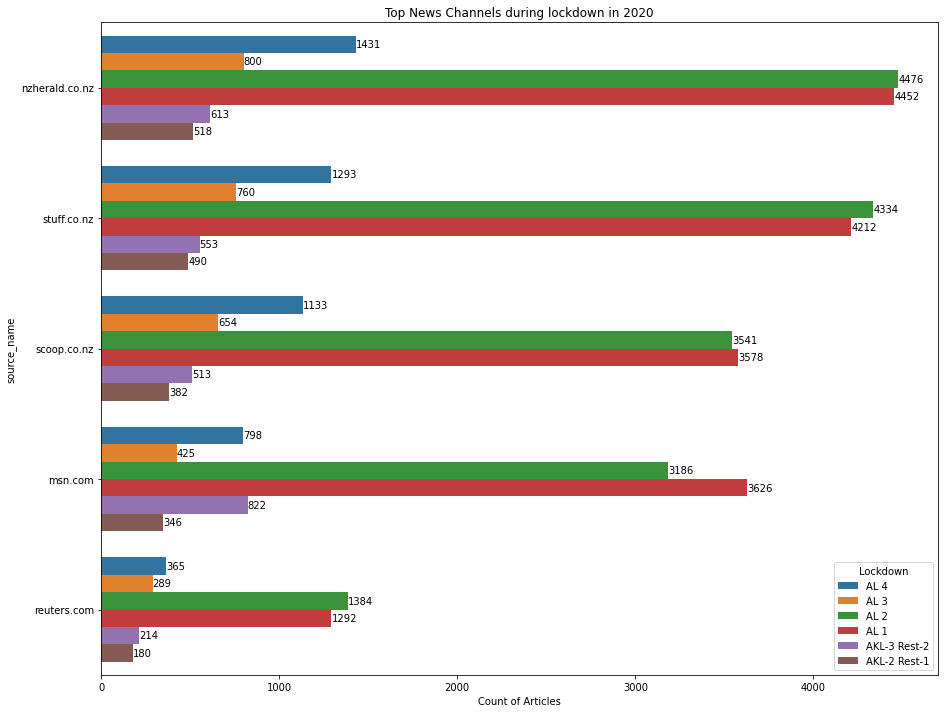

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(15,12))
ax=sns.barplot(x='Count',y='source_name',data=df_lockdown, hue = 'Lockdown', order=df1.source_name.value_counts().iloc[:5].index, ci=None)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels during lockdown in 2020")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

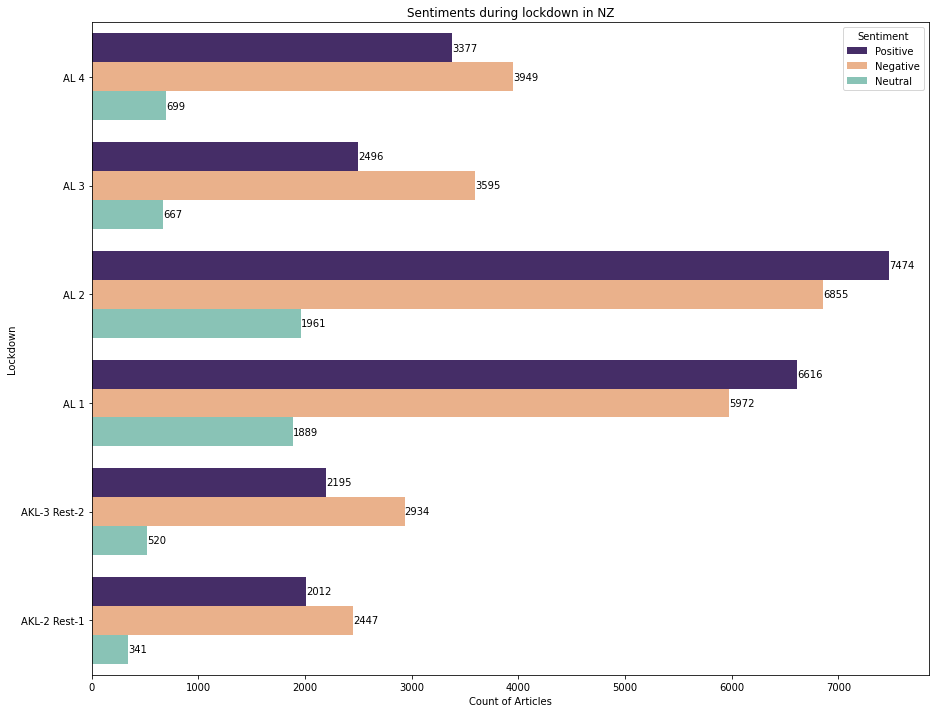

<IPython.core.display.Javascript object>

In [39]:
plt.figure(figsize=(15,12))
ax=sns.countplot(y='Lockdown',data=df_lockdown, hue = 'Sentiment',palette=['#432371',"#FAAE7B", "#7fcdbb"])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Sentiments during lockdown in NZ")
plt.xlabel("Count of Articles")

### Daily data 

In [40]:
def daily(df1):
    df1['date'] = df1['date'].dt.date
    df1_daily = df1.groupby(['date'], as_index=False).agg({'source_name':'count','tone':'mean', 'pos':'mean', 'neg':'mean', 'wc':'sum'})
    df1_daily['date'] = pd.to_datetime(df1_daily['date'], errors='coerce')
    df1_daily.rename(columns={'source_name': 'News_articles_count'}, inplace=True)
    
    return df1_daily


df1_daily = daily(df1)
df1_daily_au = daily(df1_au)


<IPython.core.display.Javascript object>

In [41]:
df1_daily[df1_daily.date.dt.month == 8]

,date,News_articles_count,tone,pos,neg,wc
213,2020-08-01,834,-1.140576,2.701192,3.841769,586453.0
214,2020-08-02,1106,-1.674182,2.479043,4.153225,1362784.0
215,2020-08-03,2795,-0.752614,2.517299,3.269914,1826098.0
216,2020-08-04,2855,-0.399976,2.550172,2.950148,1695794.0
217,2020-08-05,2647,-0.676867,2.549749,3.226617,1928571.0
218,2020-08-06,2462,-0.305992,2.681909,2.987901,1523092.0
219,2020-08-07,2053,-0.221937,2.673275,2.895212,1402693.0
220,2020-08-08,1088,0.138173,3.017839,2.879666,741903.0
221,2020-08-09,1939,-1.825008,2.558612,4.383620,1469670.0
222,2020-08-10,2621,-1.103978,2.568630,3.672608,2044073.0


<IPython.core.display.Javascript object>

In [42]:
# df1_daily.to_csv("Gdelt_NZ_2020_daily_DP.csv", index = False)
# df1_daily_au.to_csv("Gdelt_NZ_2020_daily_DP_AUSTRALIA.csv", index = False)

<IPython.core.display.Javascript object>

### S3 integration

In [43]:
import boto3

def upload_to_s3(filename):
    session = boto3.Session(profile_name='kandavar')
    dev_s3_client = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    dev_s3_client.put_object(Body=open(filename, 'rb'), Bucket = bucket_name, Key = filename)
    

def read_from_s3():
    
    session = boto3.Session(profile_name='kandavar')
    dev_s3_client = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    
    obj = dev_s3_client.get_object(Bucket = bucket_name, Key = filename)
    d = pd.read_csv(obj['Body'])

<IPython.core.display.Javascript object>

In [44]:
# upload_to_s3('Gdelt_NZ_2020_daily_DP_AUSTRALIA.csv')

<IPython.core.display.Javascript object>

### Themes

In [50]:
df1['themes'] = df1['themes'].str.split(';')

### Time series

/home/kandavar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



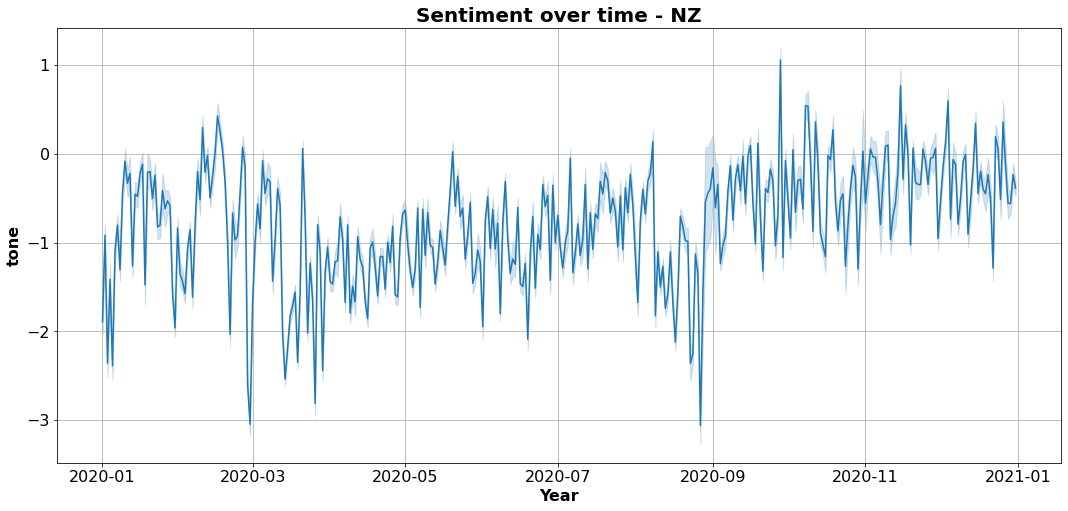

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.lineplot(df1['date'], df1['tone'] )

ax.set_title('Sentiment over time - NZ', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('tone', fontsize = 16, fontdict=dict(weight='bold'))
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [46]:
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')

<IPython.core.display.Javascript object>

/home/kandavar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Monthly Sentiment')

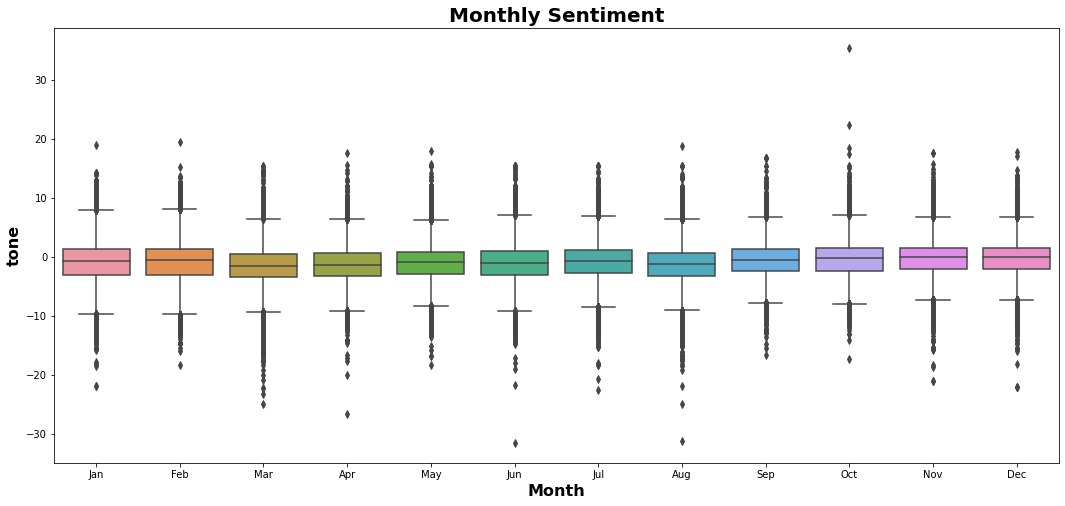

<IPython.core.display.Javascript object>

In [47]:

fig, ax = plt.subplots(figsize=(18, 8))
df1['month'] = df1['date'].dt.strftime('%b')
df1.sort_values(by = 'date', ascending = True, inplace=True)

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.boxplot(df1.month, df1.tone)
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('tone', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_title('Monthly Sentiment', fontsize = 20, loc='center', fontdict=dict(weight='bold'))


/home/kandavar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Lockdown Sentiment')

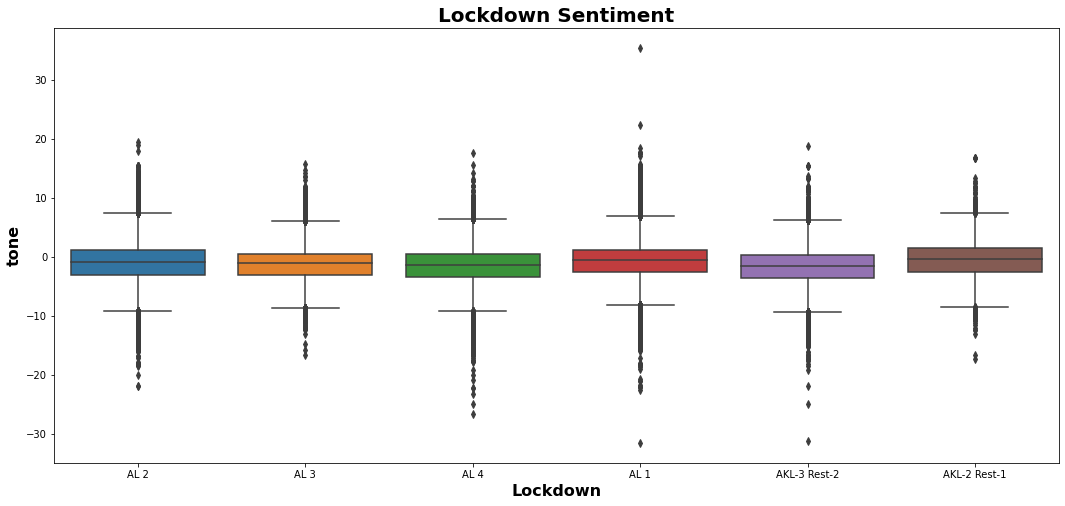

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(figsize=(18, 8))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.boxplot(df1.Lockdown, df1.tone)
ax.set_xlabel('Lockdown', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('tone', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_title('Lockdown Sentiment', fontsize = 20, loc='center', fontdict=dict(weight='bold'))

In [54]:
df_year = pd.concat([df1, df_nz_2019])
# df_year.set_index('date', drop=True, inplace=True)
# df_2019.reset_index(inplace=True)
df_year['date'] = pd.to_datetime(df_year['date'], errors='coerce')
df_year['year'] = [d.year for d in df_year.date]
df_year['month'] = [d.strftime('%b') for d in df_year.date]
years = df_year['year'].unique()
df_year.sort_values(by = 'date', ascending = True, inplace=True)

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)



<IPython.core.display.Javascript object>

/home/kandavar/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



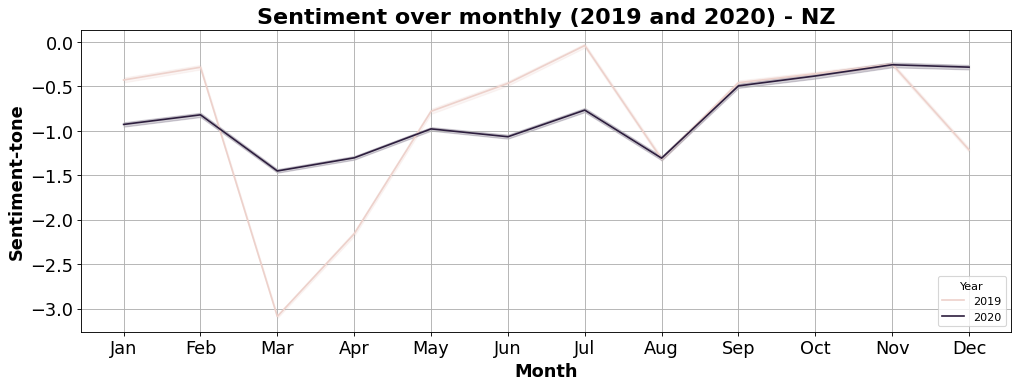

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(figsize=(15, 5), dpi = 80)


sns.lineplot(df_year['month'], df_year['tone'], hue= df_year['year'] )


ax.set_title('Sentiment over monthly (2019 and 2020) - NZ', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sentiment-tone', fontsize = 16, fontdict=dict(weight='bold'))
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'Year', loc = 'lower right',fontsize = 10)

In [56]:
def aus_nz(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df.date.dt.date
    df = df.groupby(['date'], as_index=False).agg({'tone':'mean'})
    
    return df

<IPython.core.display.Javascript object>

In [57]:
df_nz = aus_nz(df1)
df_nz['country'] = 'NZ'
df_au = aus_nz(df1_au)
df_au['country'] = 'AU'

<IPython.core.display.Javascript object>

In [58]:
df_country_wise = pd.concat([df_nz,df_au])
df_country_wise['month'] = [d.strftime('%b') for d in df_country_wise.date]
df_country_wise['date'] = pd.to_datetime(df_country_wise['date'], errors='coerce')



<IPython.core.display.Javascript object>

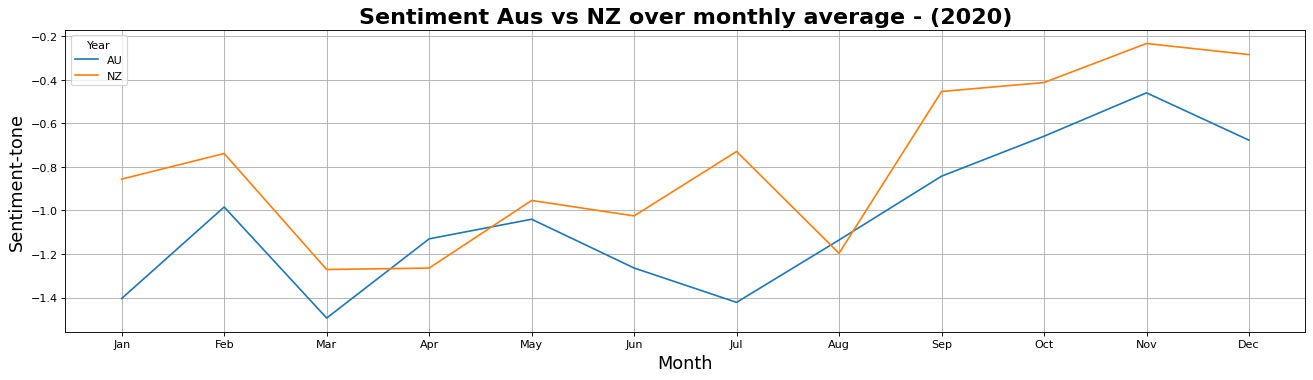

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)


sns.lineplot(x='month', y='tone', data=df_country_wise.groupby([df_country_wise.date.dt.month, 'month', 'country'], as_index=False).agg({'tone': 'mean'}), hue = 'country')


ax.set_title('Sentiment Aus vs NZ over monthly average - (2020)',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16)
ax.set_ylabel('Sentiment-tone', fontsize = 16)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.tick_params(axis='y', which='major', labelsize=16)
# plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'Year', loc = 'best',fontsize = 10)

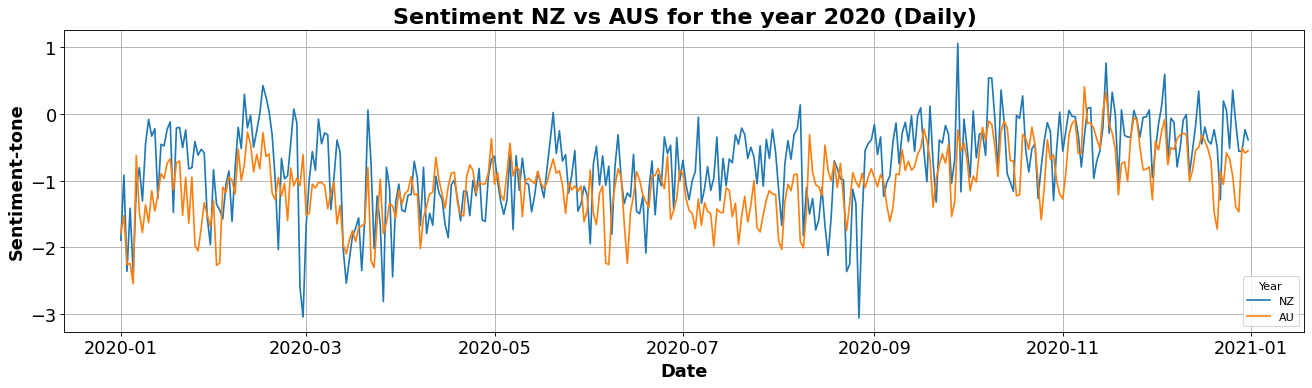

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)


sns.lineplot(x='date', y='tone', data=df_country_wise, hue = 'country')


ax.set_title('Sentiment NZ vs AUS for the year 2020 (Daily)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sentiment-tone', fontsize = 16, fontdict=dict(weight='bold'))
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'Year', loc = 'lower right',fontsize = 10)

In [61]:
df1.head()

,gkg_id,date,source,source_name,doc_id,themes,locations,persons,orgs,tone,pos,neg,polarity,ard,srd,wc,lexicode_neg,lexicode_pos,MACROECONOMICS,ENERGY,FISHERIES,TRANSPORTATION,CRIME,SOCIAL_WELFARE,HOUSING,FINANCE,DEFENCE,SSTC,FOREIGN_TRADE,CIVIL_RIGHTS,INTL_AFFAIRS,GOVERNMENT_OPS,LAND-WATER-MANAGEMENT,CULTURE,PROV_LOCAL,INTERGOVERNMENTAL,CONSTITUTIONAL_NATL_UNITY,ABORIGINAL,RELIGION,HEALTHCARE,AGRICULTURE,FORESTRY,LABOUR,IMMIGRATION,EDUCATION,ENVIRONMENT,finstab_pos,finstab_neg,finstab_neutral,finsent_neg,finsent_pos,finsent_unc,opin_neg,opin_pos,sent_pos,sent_neg,sent_pol,Lockdown,Region,Sentiment,happiness,shorter,month
572334,20200101100000-191,2020-01-01,1,vancouverisawesome.com,https://www.vancouverisawesome.com/world-news/...,WB_678_DIGITAL_GOVERNMENT;WB_694_BROADCAST_AND...,"4#Far East, Mpumalanga, South Africa#SF#SF07#-...",mariemma mejias;donald trump;eddie aikau;kwai ...,associated press;korean major league baseball,-0.293994,3.233935,3.527929,6.761865,18.731625,0.083998,2202.0,106.0,115.0,2.0,NaN,NaN,8.0,6.0,2.0,3.0,4.0,NaN,4.0,NaN,NaN,2.0,NaN,NaN,53.0,1.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN,2.0,NaN,1.0,1.0,81.0,NaN,NaN,52.0,16.0,12.0,108.0,94.0,0.249527,0.268993,NaN,AL 2,[New Zealand (General)],Negative,NaN,NaN,Jan
517552,20200101093000-769,2020-01-01,1,vancourier.com,https://www.vancourier.com/news/world/cheers-t...,WB_678_DIGITAL_GOVERNMENT;WB_694_BROADCAST_AND...,"4#Far East, Mpumalanga, South Africa#SF#SF07#-...",mariemma mejias;donald trump;eddie aikau;kwai ...,korean major league baseball,-0.294365,3.238015,3.532380,6.770395,18.671152,0.084104,2205.0,106.0,115.0,2.0,NaN,NaN,8.0,6.0,2.0,3.0,4.0,NaN,4.0,NaN,NaN,2.0,NaN,NaN,53.0,1.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN,2.0,NaN,1.0,1.0,81.0,NaN,NaN,51.0,16.0,12.0,108.0,94.0,0.249527,0.269131,NaN,AL 2,[New Zealand (General)],Negative,NaN,NaN,Jan
517551,20200101093000-737,2020-01-01,1,accesswdun.com,https://accesswdun.com/article/2020/1/863423,CRISISLEX_CRISISLEXREC;NATURAL_DISASTER;NATURA...,"4#Perth, Western Australia, Australia#AS#AS08#...",scott morrison;richard di natale;gladys bereji...,morrison;australian defence,-5.457464,1.926164,7.383628,9.309791,24.398074,0.481541,564.0,45.0,27.0,NaN,4.0,NaN,6.0,NaN,NaN,5.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,26.0,NaN,NaN,40.0,8.0,1.0,42.0,21.0,0.228181,0.305288,NaN,AL 2,[New Zealand (General)],Negative,NaN,NaN,Jan
517550,20200101093000-676,2020-01-01,1,thompsoncitizen.net,https://www.thompsoncitizen.net/australia-send...,CRISISLEX_CRISISLEXREC;NATURAL_DISASTER;NATURA...,1#Australia#AS#AS#-25#135#AS;1#New Zealand#NZ#...,scott morrison;rob rogers;richard di natale,morrison;australian defence;wales rural fire s...,-5.082212,1.943199,7.025411,8.968610,24.813154,0.597907,611.0,48.0,28.0,NaN,4.0,NaN,6.0,NaN,NaN,5.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,32.0,NaN,NaN,43.0,9.0,1.0,47.0,22.0,0.227892,0.311982,NaN,AL 2,[New Zealand (General)],Negative,NaN,NaN,Jan
517549,20200101093000-667,2020-01-01,1,accesswdun.com,https://accesswdun.com/article/2020/1/863426,WB_678_DIGITAL_GOVERNMENT;WB_694_BROADCAST_AND...,"4#Far East, Mpumalanga, South Africa#SF#SF07#-...",mariemma mejias;donald trump;eddie aikau;kwai ...,korean major league baseball,-0.336417,3.238015,3.574432,6.812447,18.671152,0.084104,2205.0,107.0,115.0,2.0,NaN,NaN,8.0,6.0,2.0,3.0,4.0,NaN,4.0,NaN,NaN,2.0,NaN,NaN,53.0,1.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN,2.0,NaN,1.0,1.0,80.0,NaN,NaN,51.0,16.0,12.0,109.0,94.0,0.249527,0.268887,NaN,AL 2,[New Zealand (General)],Negative,NaN,NaN,Jan


<IPython.core.display.Javascript object>

In [62]:
df1['Region'] = df1['Region'].agg(lambda x: ','.join(map(str, x)))


<IPython.core.display.Javascript object>

In [63]:
import swifter


import geopandas as gpd 
import geopy 
from geopy.extra.rate_limiter import RateLimiter
locator = geopy.geocoders.Nominatim(user_agent="mygeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

<IPython.core.display.Javascript object>

In [ ]:
df1['loc_map']=df1['Region'].swifter.apply(geocode)

Pandas Apply:   0%|          | 0/724927 [00:00<?, ?it/s]